In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
np.random.seed() 

In [ ]:
#define Rana 2D objective function
def rana2D(x1,x2):
    y= (x1* np.cos(np.sqrt(abs(x2+x1+1)))*np.sin(np.sqrt(abs(x2-x1+1)))) + ((1+x2)*np.cos(np.sqrt(abs(x2-x1+1)))*np.sin(np.sqrt(abs(x2+x1+1))))
    return y

#upscale x for update step, such that it varies between -500&500 instead of 0&1
def upscale_x(x):
    x_upscaled = 500*(2*x -1)
    return x_upscaled

#define a function that clips x values outside 0 to 1
def clip(x):
    if x>1:
        return 1
    if x<0:
        return 0
    else:
        return x

# generate new trial solutions by Parks, 1990
def gen_x_parks(x,D,T):
    #work with x between 0 and 1 to start with  
    D_new= np.zeros((2,2))
    x_new= np.zeros(2)
    R_kk=np.array([D[0][0]*(np.random.uniform(-1,1)) , \
                   D[1][1]*(np.random.uniform(-1,1))])
    #R=changes made to each x, so add Rkk to each x
    x_new[0]=clip(x[0]+R_kk[0])
    x_new[1]=clip(x[1]+R_kk[1])
    
    #change in obj fn value
    df= rana2D(upscale_x(x_new[0]),upscale_x(x_new[1])) - \
    rana2D(upscale_x(x[0]),upscale_x(x[1]))
    #actual step size:
    d= np.sqrt(R_kk[0]**2+ R_kk[1]**2)
    R_kk= np.fabs(R_kk)
    #update D
    D_new= np.zeros((2,2))
    D_new[0][0]= (1-damp)*D[0][0] + damp*weight*abs(R_kk[0])
    D_new[1][1]= (1-damp)*D[1][1] + damp*weight*abs(R_kk[1])
    
    #probability of accepting an increase in f
    p= np.exp(-df/(T*d))
    #decrease in f, just accept
    if df<0:
        return x_new, D_new
    #accept with prob p if f increases
    elif p > np.random.uniform(0,1):
        return x_new, D_new
    
    else:
        return x, D
        
def T0_estimate_white(x,D,Lk_init):
    #by white 1984, T0= std of list of f values observed in initial search.
    #Lk_init= number of initial search trials
    
    f_list=[]
    
    for i in range(0,Lk_init):
        D_new= np.zeros((2,2))
        x_new= np.zeros(2)
        R_kk=np.array([D[0][0]*np.random.uniform(-1,1) ,\
                       D[1][1]*np.random.uniform(-1,1)])

        x_new[0]=clip(x[0]+R_kk[0])
        x_new[1]=clip(x[1]+R_kk[1])
        R_kk= np.fabs(R_kk)
        
        D_new[0][0]= (1-damp)*D[0][0] + damp*weight*R_kk[0]
        D_new[1][1]= (1-damp)*D[1][1] + damp*weight*R_kk[1]
        
        #list of new f values, needed for T0 estimation
        f= rana2D(upscale_x(x_new[0]),upscale_x(x_new[1]))
        f_list.append(f)
        #update x and D also
        x= x_new
        D= D_new
    
    T0= np.std(f_list)
    return T0

# SA combined:
Lk_init=100


def SA_by_MC(k,Lk):
#k= number of Steps(MCs), Lkk=length of each step (MCs)
    f_list=[]
    x_list=[]
    #x0 generated randomly from seed
    x0= np.array([np.random.rand(),np.random.rand()])
    D0= np.zeros((2,2))
    D0[0][0]= x0[0]
    D0[1][1]= x0[1]
    #initialise T
    T= T0_estimate_white(x0,D0,Lk_init)
    #first update of x and D
    x,D= gen_x_parks(x0,D0,T)
    #iterate
    for i in range(0,k):
        for j in range(0,Lk):
            XX,DD= gen_x_parks(x,D,T)
            if np.any(x != XX)== True:
                x,D = XX,DD
                f_list.append(rana2D(upscale_x(x[0]),upscale_x(x[1])))
                x_list.append((upscale_x(x[0]),upscale_x(x[1])))
        #T decrement outside MC
        T*=0.95
       
    f_min=min(f_list)
    x_coords=x_list[f_list.index(f_min)]
    
    return f_list, x_list, f_min, x_coords


    
    

In [ ]:
#define params
damp=0.1
weight=2.1
Lk_init=100
k= 30
Lk= 300
num_iter=50 #run SA 50 times

#visualise function:
xvalues = yvalues = np.arange(-550, 550, 1)
X, Y = np.meshgrid(xvalues, yvalues)

zs = np.array([rana2D(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

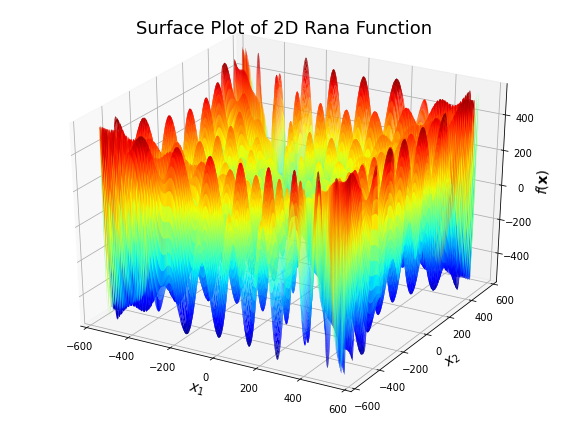

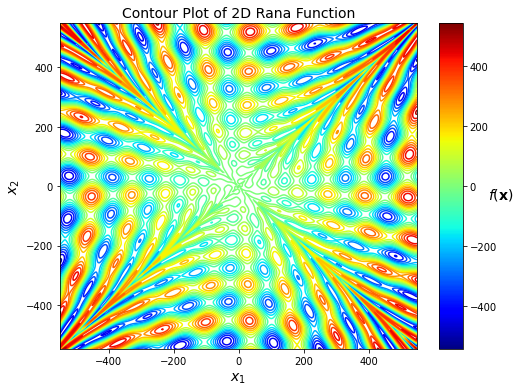

In [ ]:
#figures:

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=5, cstride=5, linewidth=0,\
                       cmap=cm.jet)
ax.set_title('Surface Plot of 2D Rana Function', fontsize=18)
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$f(\mathbf{x})$', fontsize=14)
plt.tight_layout()

plt.show()

fig2 = plt.figure(figsize=(8,6))
ax = fig2.add_subplot(1,1,1)
plt.contour(X, Y, Z, 20, cmap=cm.jet)    
ax.set_title('Contour Plot of 2D Rana Function', fontsize=14)
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
cbar = fig2.colorbar(surf, aspect=14)
cbar.set_label('$f(\mathbf{x})$', rotation=0, fontsize=14)
plt.show()


In [ ]:
one_result=SA_by_MC(k,Lk)
print(one_result[2],one_result[3])

-499.9620016605576 (500.0, 299.20697984569034)


In [ ]:
# plots for one search:
coords= one_result[1]
best_coords= one_result[3]
x1_coords= []
x2_coords= []
for i in range (0,len(coords)):
    x1_coords.append(coords[i][0])
    x2_coords.append(coords[i][1])

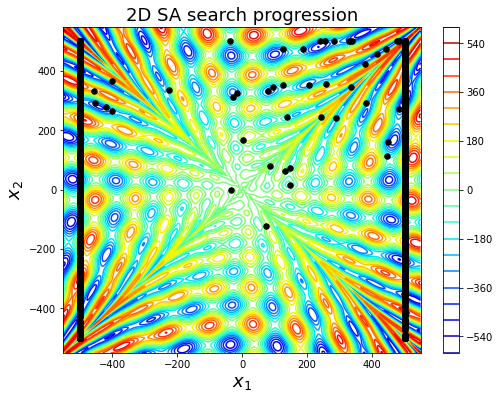

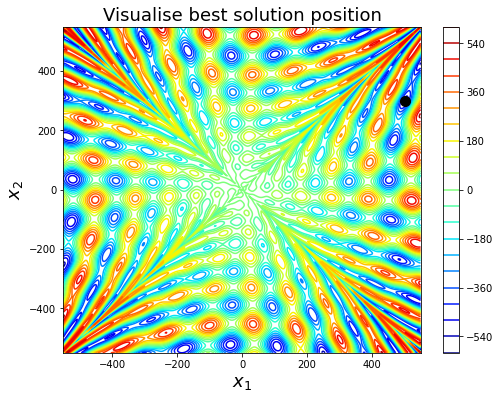

In [ ]:
fig3 = plt.figure(figsize=(8,6))
ax = fig3.add_subplot(1,1,1)
plt.contour(X, Y, Z, 20, cmap=cm.jet)
ax.scatter(x1_coords,x2_coords, color='black',s=30, zorder=1000)
#plt.plot(x1_coords,x2_coords,color='black')
ax.set_title('2D SA search progression', fontsize=18)
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
plt.colorbar()
cbar.set_label('$f(\mathbf{x})$', rotation=0, fontsize=18)
plt.show()

fig4 = plt.figure(figsize=(8,6))
ax = fig4.add_subplot(1,1,1)
ax.scatter(best_coords[0],best_coords[1],color='black', s=100,zorder=1000)
plt.contour(X, Y, Z, 20, cmap=cm.jet,zorder=2)
ax.set_title('Visualise best solution position', fontsize=18)
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
plt.colorbar()
cbar.set_label('$f(\mathbf{x})$', rotation=0, fontsize=18)
plt.show()

Text(0.5, 1.0, 'Objective value evolution of 2D RF')

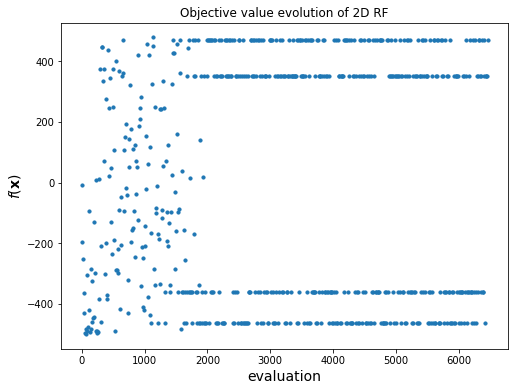

In [ ]:
fig5 = plt.figure(figsize=(8,6))
ax = fig5.add_subplot(1, 1, 1)
a_list=list(range(len(one_result[0])))
a2_list= a_list[::10]
b_list= one_result[0]
b2_list= b_list[::10]
ax.scatter(a2_list, b2_list,s=10)
plt.xlabel('evaluation', Fontsize=14)
plt.ylabel('$f(\mathbf{x})$', Fontsize=14)
plt.title('Objective value evolution of 2D RF')

In [ ]:
obj_fn_list=[]
f_min_list=[]
x_coords_list=[]
for i in range(0,num_iter):
    RESULTS=SA_by_MC(k,Lk)
    f_min_list.append(RESULTS[2])
    x_coords_list.append(RESULTS[3])
    obj_fn_list.append(RESULTS[0])
f_min_final= min(f_min_list)
x_coord_final= x_coords_list[f_min_list.index(f_min_final)]

print(f_min_final, x_coord_final)


-500.8019135059829 (-300.31696716326223, 500.0)


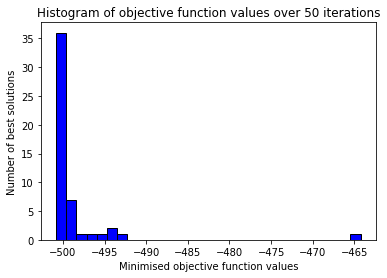

In [ ]:
#plot histogram of f_min_list over num_iter iterations
plt.hist(f_min_list, 30, color='blue', histtype='bar', ec='black')
plt.title('Histogram of objective function values over 50 iterations')
plt.xlabel('Minimised objective function values')
plt.ylabel('Number of best solutions')
plt.show()

In [ ]:
print(np.std(f_min_list))
print(np.mean(f_min_list))
print(min(f_min_list))

5.255808418570463
-498.79121632666624
-500.8019135059829


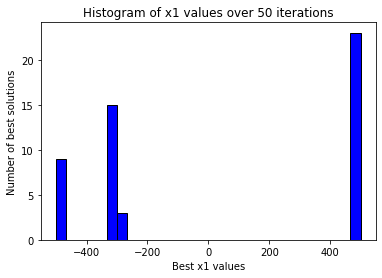

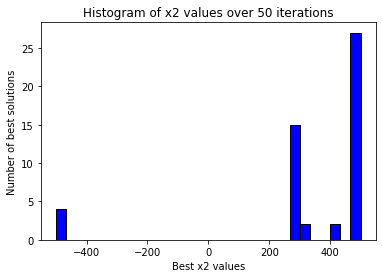

In [ ]:
x1_best= []
x2_best= []
for i in range (0,len(x_coords_list)):
    x1_best.append(x_coords_list[i][0])
    x2_best.append(x_coords_list[i][1])
plt.hist(x1_best, 30, color='blue', histtype='bar', ec='black')
plt.title('Histogram of x1 values over 50 iterations')
plt.xlabel('Best x1 values')
plt.ylabel('Number of best solutions')
plt.show()
plt.hist(x2_best, 30, color='blue', histtype='bar', ec='black')
plt.title('Histogram of x2 values over 50 iterations')
plt.xlabel('Best x2 values')
plt.ylabel('Number of best solutions')
plt.show()